In [1]:
####
## Celso Antonio Uliana Junior
## July 2 2020
####

import pandas as pd

#####
## Consuming and shaping the data to analysis
## Covid-19 numbers in Brazil by date
## Isolation percentage in Brazil by date
#####

data_raw_covid = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/covidBrasil.csv", sep = ";", decimal = ",")
data_raw_isolation = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/isolamento.csv", sep = ";", decimal = ",")
data_covid = data_raw_covid['Data'].values.copy()
data_covid = data_raw_covid.dropna().set_index("Data")
data_isolation = data_raw_isolation['Data'].values.copy()
data_isolation = data_raw_isolation.dropna().set_index("Data")

####
## Shaping a central pandas dataFrame for all our ML needs
####

data = data_covid
data['Taxa'] = data_isolation['Taxa'].values.copy()


In [2]:
from sklearn.preprocessing import MinMaxScaler

####
## normalizing values for both covid and isolation percentage 
## between range [0,1] using sklearn MinMaxScaler
####

covid_norm = data_covid["Casos"].values.copy()
covid_norm.shape = (len(covid_norm), 1)

isolation_norm = data_isolation["Taxa"].values.copy()
isolation_norm.shape = (len(isolation_norm), 1)

####
## Shaping the central dataFrame with normalized values
####
min_max_scaler = MinMaxScaler()

covid_norm = min_max_scaler.fit_transform(covid_norm)
isolation_norm = min_max_scaler.fit_transform(isolation_norm)

data["CasosNormalizados"] = covid_norm
data["TaxaNormalizadas"] = isolation_norm
data.head(20)

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas
Data,,,,
26/2/20,1,24.7,0.000018,0.000000
27/2/20,0,27.5,0.000000,0.074667
28/2/20,0,26.6,0.000000,0.050667
29/2/20,0,31.4,0.000000,0.178667
1/3/20,1,42,0.000018,0.461333
2/3/20,0,27.7,0.000000,0.080000
3/3/20,0,29,0.000000,0.114667
4/3/20,0,30.2,0.000000,0.146667
5/3/20,1,29.7,0.000018,0.133333


In [3]:
####
## Sliding window
## This example of sliding window looks at past data
####
df = pd.DataFrame()
window_size = 7
for i in range(0, window_size + 1):
    df['E{}'.format(i)] = data['CasosNormalizados'].shift(+i)
    if(i == window_size):
        for j in range(0, window_size + 1):
             df['E{}'.format(j + i + 1)] = data['TaxaNormalizadas'].shift(+j)
df = df.iloc[window_size:]
print(df)

               E0        E1        E2        E3        E4        E5        E6  \
Data                                                                            
4/3/20   0.000000  0.000000  0.000000  0.000018  0.000000  0.000000  0.000000   
5/3/20   0.000018  0.000000  0.000000  0.000000  0.000018  0.000000  0.000000   
6/3/20   0.000091  0.000018  0.000000  0.000000  0.000000  0.000018  0.000000   
7/3/20   0.000091  0.000091  0.000018  0.000000  0.000000  0.000000  0.000018   
8/3/20   0.000000  0.000091  0.000091  0.000018  0.000000  0.000000  0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
17/6/20  0.637527  0.376970  0.312392  0.396268  0.474375  0.555257  0.600920   
18/6/20  0.587683  0.637527  0.376970  0.312392  0.396268  0.474375  0.555257   
19/6/20  0.415640  0.587683  0.637527  0.376970  0.312392  0.396268  0.474375   
20/6/20  1.000000  0.415640  0.587683  0.637527  0.376970  0.312392  0.396268   
21/6/20  0.632926  1.000000 

In [4]:
####
## Manipulating the data to split into X(a window size of values)
## and target, or Y, the value X "produces"
####

arr = df.values
#print(arr)
X = arr[:, 1:]
target = arr[:, 0]
#target = arr[:, -1]
print(X)
print(target)

[[0.00000000e+00 0.00000000e+00 1.82578372e-05 ... 5.06666667e-02
  7.46666667e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.78666667e-01
  5.06666667e-02 7.46666667e-02]
 [1.82578372e-05 0.00000000e+00 0.00000000e+00 ... 4.61333333e-01
  1.78666667e-01 5.06666667e-02]
 ...
 [5.87683263e-01 6.37527159e-01 3.76969564e-01 ... 6.45333333e-01
  4.10666667e-01 3.22666667e-01]
 [4.15639663e-01 5.87683263e-01 6.37527159e-01 ... 3.81333333e-01
  6.45333333e-01 4.10666667e-01]
 [1.00000000e+00 4.15639663e-01 5.87683263e-01 ... 3.84000000e-01
  3.81333333e-01 6.45333333e-01]]
[0.00000000e+00 1.82578372e-05 9.12891859e-05 9.12891859e-05
 0.00000000e+00 2.19094046e-04 0.00000000e+00 1.64320535e-04
 3.28641069e-04 4.56445929e-04 3.83414581e-04 4.19930255e-04
 1.44236914e-03 6.20766464e-04 1.04069672e-03 2.50132369e-03
 3.52376258e-03 5.16696792e-03 4.08975553e-03 7.63177594e-03
 6.29895383e-03 5.65992952e-03 4.23581822e-03 8.80027752e-03
 9.16543426e-03 8.89156671e-03 6.4

In [5]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

mlp = MLPRegressor(
    hidden_layer_sizes = (50,),  activation = 'relu', solver = 'adam', alpha = 0.001, batch_size = 'auto',
    learning_rate = 'constant', learning_rate_init = 0.01, power_t = 0.5, max_iter = 1000, shuffle = True,
    random_state = 9, tol = 0.0001, verbose = True, warm_start = False, momentum = 0.9, nesterovs_momentum = True,
    early_stopping = False, validation_fraction = 0.1, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
svr = SVR(kernel = 'linear', C = 0.25, epsilon = 0.01, verbose = True, max_iter = 1000)
lr = LinearRegression()

full_predict_lr = cross_val_predict(lr, X, target, cv = 10)
full_predict_mlp = cross_val_predict(mlp, X, target, cv = 10)
full_predict_svr = cross_val_predict(svr, X, target, cv = 10)

Iteration 1, loss = 0.02549379
Iteration 2, loss = 0.04125927
Iteration 3, loss = 0.00923964
Iteration 4, loss = 0.01201848
Iteration 5, loss = 0.01679625
Iteration 6, loss = 0.00898705
Iteration 7, loss = 0.00747733
Iteration 8, loss = 0.01253872
Iteration 9, loss = 0.01302380
Iteration 10, loss = 0.00854899
Iteration 11, loss = 0.00511796
Iteration 12, loss = 0.00532676
Iteration 13, loss = 0.00661995
Iteration 14, loss = 0.00616137
Iteration 15, loss = 0.00431955
Iteration 16, loss = 0.00324205
Iteration 17, loss = 0.00390526
Iteration 18, loss = 0.00520020
Iteration 19, loss = 0.00555666
Iteration 20, loss = 0.00477520
Iteration 21, loss = 0.00387134
Iteration 22, loss = 0.00367111
Iteration 23, loss = 0.00399057
Iteration 24, loss = 0.00406805
Iteration 25, loss = 0.00355866
Iteration 26, loss = 0.00287243
Iteration 27, loss = 0.00260039
Iteration 28, loss = 0.00282473
Iteration 29, loss = 0.00307601
Iteration 30, loss = 0.00301215
Iteration 31, loss = 0.00277667
Iteration 32, los

Iteration 27, loss = 0.00318182
Iteration 28, loss = 0.00297995
Iteration 29, loss = 0.00270347
Iteration 30, loss = 0.00267933
Iteration 31, loss = 0.00277141
Iteration 32, loss = 0.00266649
Iteration 33, loss = 0.00237587
Iteration 34, loss = 0.00219160
Iteration 35, loss = 0.00225379
Iteration 36, loss = 0.00238019
Iteration 37, loss = 0.00236765
Iteration 38, loss = 0.00225690
Iteration 39, loss = 0.00221017
Iteration 40, loss = 0.00232371
Iteration 41, loss = 0.00226875
Iteration 42, loss = 0.00209060
Iteration 43, loss = 0.00209815
Iteration 44, loss = 0.00214570
Iteration 45, loss = 0.00207961
Iteration 46, loss = 0.00204021
Iteration 47, loss = 0.00209585
Iteration 48, loss = 0.00208234
Iteration 49, loss = 0.00199654
Iteration 50, loss = 0.00196436
Iteration 51, loss = 0.00198246
Iteration 52, loss = 0.00196673
Iteration 53, loss = 0.00193900
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.02278803
Iteration 2, lo

In [6]:
print('Mean Squared Error in MLP: %s' %(metrics.mean_squared_error(target, full_predict_mlp)))
print('Mean Squared Error in SVR: %s' %(metrics.mean_squared_error(target, full_predict_svr)))
print('Mean Squared Error in LR: %s' %(metrics.mean_squared_error(target, full_predict_lr)))

print(len(full_predict_mlp))
print(len(full_predict_svr))
print(len(full_predict_lr))

print(len(data['CasosNormalizados']))

Mean Squared Error in MLP: 0.005351183470762157
Mean Squared Error in SVR: 0.005370567413634218
Mean Squared Error in LR: 0.006393508596587951
110
110
110
117


In [7]:
import numpy as np

values_to_add = list()
for i in range(0, window_size):
    values_to_add.append(float('NaN'))
    
full_predict_svr = np.insert(full_predict_svr, 0, values_to_add)
full_predict_svr.shape = (len(full_predict_svr), 1)
    
full_predict_mlp = np.insert(full_predict_mlp, 0, values_to_add)
full_predict_mlp.shape = (len(full_predict_mlp), 1)

full_predict_lr = np.insert(full_predict_lr, 0, values_to_add)
full_predict_lr.shape = (len(full_predict_lr), 1)

print(full_predict_svr.shape)
print(full_predict_mlp.shape)
print(full_predict_lr.shape)

(117, 1)
(117, 1)
(117, 1)


In [8]:
data['Predict_lr'] = full_predict_lr
data['Predict_mlp'] = full_predict_mlp
data['Predict_svr'] = full_predict_svr
data

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas,Predict_lr,Predict_mlp,Predict_svr
Data,,,,,,,
26/2/20,1,24.7,0.000018,0.000000,NaN,NaN,NaN
27/2/20,0,27.5,0.000000,0.074667,NaN,NaN,NaN
28/2/20,0,26.6,0.000000,0.050667,NaN,NaN,NaN
29/2/20,0,31.4,0.000000,0.178667,NaN,NaN,NaN
1/3/20,1,42,0.000018,0.461333,NaN,NaN,NaN
...,...,...,...,...,...,...,...
17/6/20,34918,37.3,0.637527,0.336000,0.643119,0.599717,0.578741
18/6/20,32188,38.5,0.587683,0.368000,0.704982,0.603563,0.624069
19/6/20,22765,34.7,0.415640,0.266667,0.597476,0.551969,0.569167


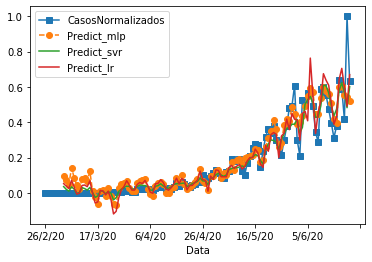

In [9]:
import matplotlib.pyplot as plt
data.plot(y=['CasosNormalizados', 'Predict_mlp', 'Predict_svr', 'Predict_lr'], style=['-s', '--o'])
plt.show()